In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchdiffeq import odeint
from tqdm import tqdm

Helper code:

In [29]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

def get_xyz(y_tensor, t_tensor, start_xyz=[[],[],[]]):
    """
    A function to calculate the position array of a particle based on a tensor of it's velocities at each time t in a time tensor.
    """
    # use suvat s = ut + 1/2at**2 === ut neglecting resistive forces
    x, y, z = start_xyz
    t_arr=t_tensor.cpu().numpy()
    u_arr = y_tensor.cpu().numpy()[:,0,0]
    v_arr = y_tensor.cpu().numpy()[:,0,1]
    w_arr = y_tensor.cpu().numpy()[:,0,2]
    dt = t_arr[1] - t_arr[0]
    dx = [u * dt for u in u_arr]
    dy = [v * dt for v in v_arr]
    dz = [z * dt for z in w_arr]
    for _dx, _dy, _dz in zip(dx, dy, dz):
        x.append(x[-1]+_dx if x else _dx)
        y.append(y[-1]+_dy if y else _dy)
        z.append(z[-1]+_dz if z else _dz)
    
    return np.array(x),np.array(y),np.array(z)


Lorentz equations:

In [3]:
#  From https://scipython.com/blog/the-lorenz-attractor/
# Lorenz parameters and initial conditions.
sigma, beta, rho = 10, 2.667, 28
true_y0 = torch.tensor([[0, 1, 1.05]]).to(device)     # starting vector for ODE

class Lambda(nn.Module):
    def forward(self, t, y):
        """The Lorenz equations."""
        u, v, w = y[0]
        up = -sigma*(u - v)
        vp = rho*u - v - u*w
        wp = -beta*w + u*v
        return torch.tensor([[up, vp, wp]]).to(device)

Obtain true values from numerical DE solver:

In [5]:
t = torch.linspace(0., 25., 1000).to(device) # time over which ODE is integrated

with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5') # calculate true_y values
true_y

tensor([[[ 0.0000,  1.0000,  1.0500]],

        [[ 0.2247,  1.0529,  0.9851]],

        [[ 0.4278,  1.2454,  0.9306]],

        ...,

        [[ 9.4671, 14.7670, 19.7274]],

        [[10.8097, 16.1635, 22.2666]],

        [[12.0994, 16.9408, 25.4477]]])

Define Neural ODE:

In [40]:
class ODENN(nn.Module):

    def __init__(self):
        super(ODENN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(3, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 3),
        )

        for m in self.layers.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.layers(y)
    
    def trainmodel(self, true_y, t, optimizer, epochs, train_ratio=1):
        validation = False if train_ratio == 1 else True
        train_y = true_y[:int(len(true_y)*train_ratio)]
        train_t = t[:int(len(t)*train_ratio)]
        validation_y = true_y[int(len(true_y)*train_ratio):]
        validation_t = t[int(len(t)*train_ratio):]
        train_losses, validation_losses, iterations = [],[],[]
        for epoch in tqdm(range(epochs)):
            pred_y = odeint(self, train_y[0], train_t).to(device)
            loss = torch.mean(torch.abs(pred_y - train_y))
            loss.backward()
            optimizer.step()
            iterations.append(epoch)
            train_losses.append(float(loss))
            if validation:
                pred_y = self.predict(validation_y[0], validation_t)
                loss = torch.mean(torch.abs(pred_y - validation_y))
                validation_losses.append(float(loss))

        plt.plot(iterations, train_losses, label='training loss')
        if validation:
            plt.plot(iterations, validation_losses, label='validation loss')
        plt.xlabel('iteration')
        plt.ylabel('loss')
        plt.legend()
        plt.show()
        print(f"Final training loss: {train_losses[-1]}")
    
    def predict(self, y0, t):
        with torch.no_grad():
            pred_y = odeint(self, y0, t).to(device)
        return pred_y
        

        

train loop:

In [16]:
def train(net, true_y, t, optimizer, epochs):
        losses, iterations = [],[]
        for epoch in range(epochs):
            pred_y = odeint(net, true_y[0], t).to(device)
            loss = torch.mean(torch.abs(pred_y - true_y))
            loss.backward()
            optimizer.step()
            iterations.append(epoch)
            losses.append(float(loss))

        plt.plot(iterations, losses)
        print(f"Final loss: {losses[-1]}")

100%|██████████| 200/200 [01:32<00:00,  2.16it/s]


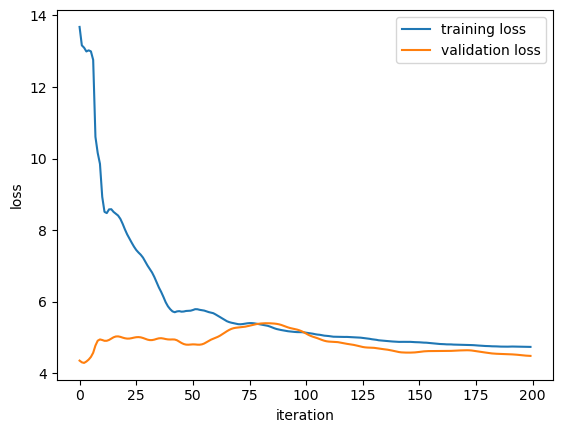

Final training loss: 4.7369465827941895


In [41]:
net=ODENN().to(device)
optimizer = optim.RMSprop(net.parameters(), lr=0.0001)
net.trainmodel(true_y, t, optimizer, epochs=200, train_ratio=0.9)

100%|██████████| 200/200 [03:58<00:00,  1.19s/it]

Final loss: 4.683211326599121


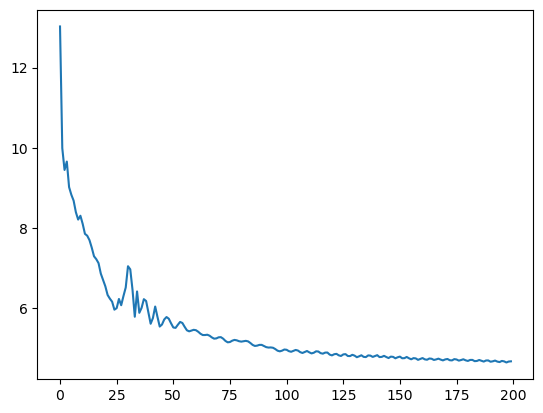

In [22]:
# epochs=200
# losses, iterations = [],[]
# net = ODENN().to(device)
# optimizer = optim.RMSprop(net.parameters(), lr=1e-4)
# for epoch in tqdm(range(epochs)):
#     pred_y = odeint(net, true_y0, t).to(device)
#     loss = torch.mean(torch.abs(pred_y - true_y))
#     loss.backward()
#     optimizer.step()
#     iterations.append(epoch)
#     losses.append(float(loss))

# plt.plot(iterations, losses)
# print(f"Final loss: {losses[-1]}")

Plotting:

In [76]:
def plot(true_vels, pred_vels, t):
    fig = plt.figure(figsize=(12, 4), facecolor='white')
    ax_traj = fig.add_subplot(121, frameon=False)
    ax_phase = fig.add_subplot(122, projection='3d')

    true_sx, true_sy, true_sz = get_xyz(true_vels, t)
    pred_sx, pred_sy, pred_sz = get_xyz(pred_vels, t)

    ax_traj.cla()
    ax_traj.set_title('Trajectories')
    ax_traj.set_xlabel('t')
    ax_traj.set_ylabel('x,y,z')
    ax_traj.plot(t.cpu().numpy(), true_sx, 'k-', label='true x')
    ax_traj.plot(t.cpu().numpy(), true_sy, 'm-', label='true y')
    ax_traj.plot(t.cpu().numpy(), true_sz, 'b-', label='true z')
    ax_traj.plot(t.cpu().numpy(), pred_sx, 'k--', label='predicted x')
    ax_traj.plot(t.cpu().numpy(), pred_sy, 'm--', label='predicted y')
    ax_traj.plot(t.cpu().numpy(), pred_sz, 'b--', label='predicted z')
    ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
    #ax_traj.set_ylim(-2, 2)
    ax_traj.legend()

    ax_phase.cla()
    ax_phase.set_title('Phase Portrait')
    ax_phase.plot(true_sx, true_sy, true_sz, 'g--', label="True")

    s=10
    n=len(t)
    line_segments = [(pred_sx[i:i+s+1], pred_sy[i:i+s+1], pred_sz[i:i+s+1]) for i in range(0,n-s,s)]
    segment_colours = [plt.cm.winter(i/n) for i in range(0,n-s,s)]
    #lines = Line3DCollection(line_segments, colors = segment_colours, label='Predicted')
    #ax_phase.add_collection(lines)
    for i, line in enumerate(line_segments):
        ax_phase.plot(line[0], line[1], line[2], color = segment_colours[i])

    #ax_phase.plot(pred_x, pred_y, pred_z, 'b--')
    ax_phase.set_xlabel('x')
    ax_phase.set_ylabel('y')
    ax_phase.set_zlabel('z')
    ax_phase.legend()
    plt.show()

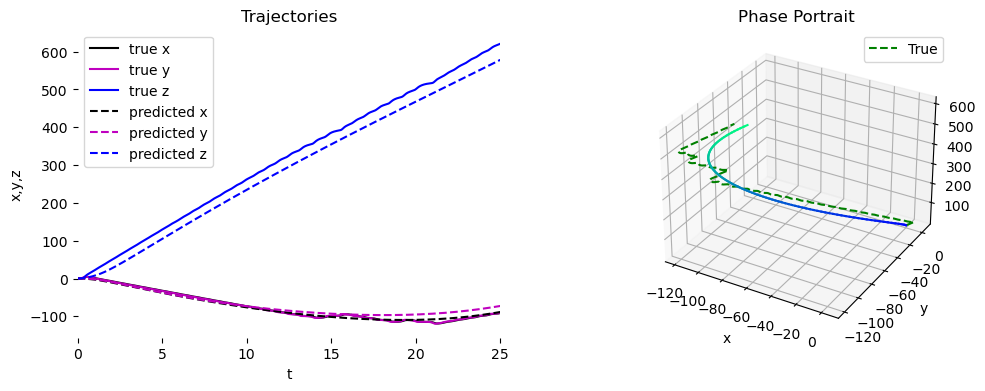

In [52]:
true_vels=true_y
with torch.no_grad():
    pred_vels=odeint(net, true_y0, t).to(device)
plot(true_vels, pred_vels, t)

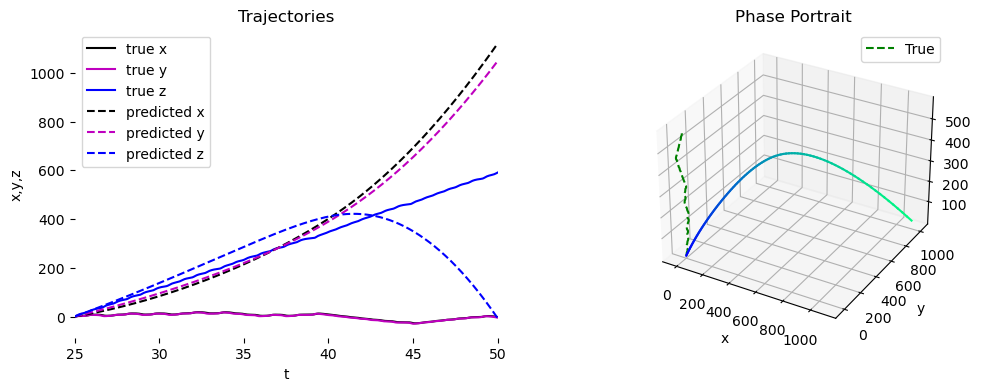

In [53]:
t_extended = torch.linspace(25., 50., data_size).to(device) # time over which ODE is integrated

with torch.no_grad():
    true_vels_extended = odeint(Lambda(), true_y[-1], t_extended, method='dopri5') # calculate true_y values
    pred_vels_extended = odeint(net, true_y[-1], t_extended).to(device)
plot(true_vels_extended, pred_vels_extended, t_extended)

In [55]:
import copy
def predict_trajectory(net, y0, t, s0=[[],[],[]]):
        pred_vels = net.predict(y0, t)
        true_vels = odeint(Lambda(), y0, t, method='dopri5')
        pred_sx, pred_sy, pred_sz = get_xyz(pred_vels, t, start_xyz=copy.deepcopy(s0))
        true_sx, true_sy, true_sz = get_xyz(true_vels, t, start_xyz=copy.deepcopy(s0))

        fig = plt.figure(figsize=(12, 4), facecolor='white')
        ax_traj = fig.add_subplot(121, frameon=False)
        ax_phase = fig.add_subplot(122, projection='3d')

        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y,z')
        ax_traj.plot(t.cpu().numpy(), true_sx, 'k-', label='true x')
        ax_traj.plot(t.cpu().numpy(), true_sy, 'm-', label='true y')
        ax_traj.plot(t.cpu().numpy(), true_sz, 'b-', label='true z')
        ax_traj.plot(t.cpu().numpy(), pred_sx, 'k--', label='predicted x')
        ax_traj.plot(t.cpu().numpy(), pred_sy, 'm--', label='predicted y')
        ax_traj.plot(t.cpu().numpy(), pred_sz, 'b--', label='predicted z')
        ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
        #ax_traj.set_ylim(-2, 2)
        ax_traj.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.plot(true_sx, true_sy, true_sz, 'g--', label="True")

        s=10
        n=len(t)
        line_segments = [(pred_sx[i:i+s+1], pred_sy[i:i+s+1], pred_sz[i:i+s+1]) for i in range(0,n-s,s)]
        segment_colours = [plt.cm.winter(i/n) for i in range(0,n-s,s)]
        #lines = Line3DCollection(line_segments, colors = segment_colours, label='Predicted')
        #ax_phase.add_collection(lines)
        for i, line in enumerate(line_segments):
            ax_phase.plot(line[0], line[1], line[2], color = segment_colours[i])

        #ax_phase.plot(pred_x, pred_y, pred_z, 'b--')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.set_zlabel('z')
        ax_phase.legend()
        plt.show()

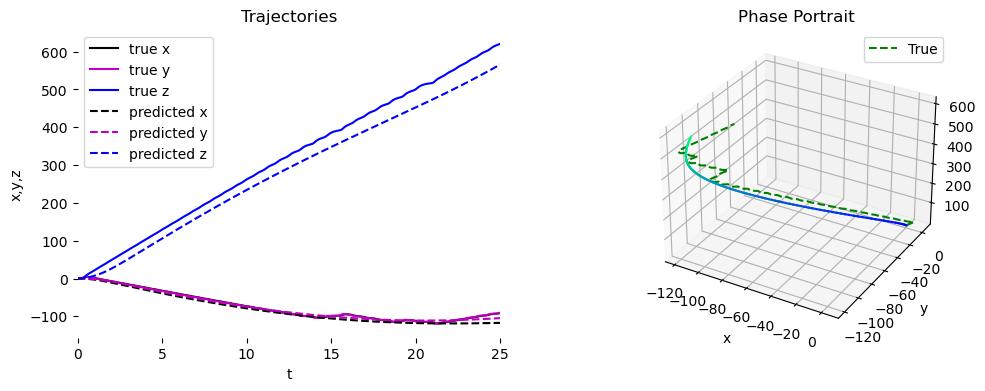

In [56]:
predict_trajectory(net, true_y[0], t)
t_extended

In [58]:
pred_y = net.predict(true_y[0], t)

fig = plt.figure(figsize=(12, 4), facecolor='white')
ax_traj = fig.add_subplot(121, frameon=False)
ax_phase = fig.add_subplot(122, projection='3d')

ax_traj.cla()
ax_traj.set_title('Trajectories')
ax_traj.set_xlabel('t')
ax_traj.set_ylabel('x,y,z')
ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,:,0], 'k-', label='true x')
ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,:,1], 'm-', label='true y')
ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:,:,2], 'b-', label='true z')
ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,:,0], 'k--', label='predicted x')
ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,:,1], 'm--', label='predicted y')
ax_traj.plot(t.cpu().numpy(), pred_y.cpu().numpy()[:,:,2], 'b--', label='predicted z')
ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
#ax_traj.set_ylim(-2, 2)
ax_traj.legend()

ax_phase.cla()
ax_phase.set_title('Phase Portrait')
ax_phase.plot(true_y.cpu().numpy()[:,:,0], true_y.cpu().numpy()[:,:,1], true_y.cpu().numpy()[:,:,2], 'g--', label="True")

s=10
n=len(t)
line_segments = [(pred_y.cpu().numpy()[:,:,0][i:i+s+1], pred_y.cpu().numpy()[:,:,1][i:i+s+1], pred_y.cpu().numpy()[:,:,2][i:i+s+1]) for i in range(0,n-s,s)]
segment_colours = [plt.cm.winter(i/n) for i in range(0,n-s,s)]
#lines = Line3DCollection(line_segments, colors = segment_colours, label='Predicted')
#ax_phase.add_collection(lines)
for i, line in enumerate(line_segments):
    ax_phase.plot(line[0], line[1], line[2], color = segment_colours[i])

#ax_phase.plot(pred_x, pred_y, pred_z, 'b--')
ax_phase.set_xlabel('x')
ax_phase.set_ylabel('y')
ax_phase.set_zlabel('z')
ax_phase.legend()
plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3444155971.py, line 11)

In [49]:
print(pred_vels_extended[:5])
print(pred_vels[:5])

tensor([[[ 0.0000,  1.0000,  1.0500]],

        [[-0.1387,  0.8528,  1.3482]],

        [[-0.2781,  0.7059,  1.6484]],

        [[-0.4179,  0.5593,  1.9497]],

        [[-0.5578,  0.4132,  2.2518]]])
tensor([[[ 0.0000,  1.0000,  1.0500]],

        [[-0.1387,  0.8528,  1.3482]],

        [[-0.2781,  0.7059,  1.6484]],

        [[-0.4179,  0.5593,  1.9497]],

        [[-0.5578,  0.4132,  2.2518]]])
